# Импорт библиотек

In [1]:
import numpy as np
from gzip import open # NB: overrides standard open()
import pickle as pkl
import pandas as pd
import warnings 
from glob import glob
import os
import math
import functools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from numpy import linalg as LA
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib as mpl

### Отключим предупреждения Anaconda

In [3]:
warnings.simplefilter('ignore')

# Загрузим данные

In [4]:
Xdata_numpy = pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/X.pkl.gz', 'rb'))
Ydata = pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/y.pkl.gz', 'rb'))

In [28]:
Xdata_numpy

{'X': array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.0237846 , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.02531928, ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.02805651, ..., 0.        ,
          0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.02737534, ..., 0.        ,
          0.       

# N-PLS1
## Приближение к правильному алгоритму
### Опишу ка я центрирование в виде класса, для удобства.

In [5]:
class centrir(BaseEstimator):
    """"Этот класс производит центрирование, а потом из центрированных данных переходит обратно"""
    def  __init__(self, testSize=2*0.02857, column_y=0):
        self.testSize = testSize
        self.column_y=column_y
    
    def centering_and_cv(self,xx,yy):
        x=xx.copy()
        y=yy.copy()
        x_centrir=np.array(x)
        y_centrir=y.iloc[:,self.column_y].to_numpy()
        x_centrir -= x_centrir.mean(axis = 0)
        #x_centrir -= x_centrir.mean()
        self.medium=y_centrir.mean() #Это сренее значение у. 
        y_centrir -= y_centrir.mean() 
        
        X_train, X_test, y_train, y_test = train_test_split(
                x_centrir, y_centrir, test_size=self.testSize 
                )
        self.X_train=X_train
        self.X_test=X_test
        self.y_train=y_train
        self.y_test=y_test
        return self
    
    def recentering(self,yy):
            y=yy.copy()
            y+=self.medium
            return y
        

In [6]:
class Tri_PLS1_grid(RegressorMixin,BaseEstimator):
    def  __init__(self, n_components=2):
        self.n_components = n_components
        
            
    def fit(self, xx, yy):
        """Fits the model to the data (X, y)

        Parameters
        ----------
        X : ndarray
        y : 1D-array of shape (n_samples, )
            labels associated with each sample"""
        x=xx.copy()
        y=yy.copy()        
        Tt=np.zeros([x.shape[0],self.n_components])
        mass=np.zeros([y.shape[0]])
        y_copy=yy.copy()
        """"
        При различных способах разрезания исходных данных, массивы w_k и w_i имеют похожие значения и именно их я планирую 
        использовать для функции predict данного класса. """
        w_k_mass=np.zeros([self.n_components,x.shape[1],1])
        w_i_mass=np.zeros([self.n_components,x.shape[2],1])
        bf_array=[]
        for f in range(0,self.n_components):
            z=np.zeros([x.shape[1],x.shape[2]])
            x_product=np.zeros([x.shape[0],x.shape[1],x.shape[2]])
            for i in range(0,x.shape[0]):
                x_product[i,:,:]=x[i,:,:]*y[i]
            z=x_product.sum(axis=0)
            Wk, S, WI = np.linalg.svd(z)
            w_k=np.array(Wk[0,:]).reshape(x.shape[1],1)
            w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
            w_k_mass[f,:,:]=w_k
            w_i_mass[f,:,:]=w_i
            
            for h in range(0,x.shape[0]):
                 Tt[h,f]=np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)
            T=np.array(Tt[:,0:f+1]).reshape(x.shape[0],f+1)
            bf=np.dot(np.dot(np.linalg.inv(np.dot(T.transpose(),T)),T.transpose()),y)
            bf_array+=[bf]
            mmas=np.kron(Tt[:,f],np.kron(w_i,w_k).reshape(x.shape[1],x.shape[2])).reshape(x.shape[0],x.shape[1],x.shape[2])
            x=x-(mmas)             
            y=y-(np.dot(T,bf))
            mass+=np.dot(T,bf)   
        self.bf_array=bf_array
        self.train_error=mean_squared_error(mass,y_copy)
        self.w_k=w_k_mass
        self.w_i=w_i_mass
        
        return self
    
    
    def predict(self, xx):
        x=xx.copy()
        xn=x.reshape(x.shape[0],x.shape[1]*x.shape[2])
        wk=np.array(self.w_k[0,:,:]).reshape(x.shape[1],1)
        wj=np.array(self.w_i[0,:,:]).reshape(x.shape[2],1)
        ww=np.kron(wk,wj).reshape(xn.shape[1])
        R=np.zeros([xn.shape[1],self.n_components])
        t=np.zeros([self.n_components,x.shape[0]])
        R[:,0]=ww.reshape(xn.shape[1])
        t[0,:]=np.dot(xn.copy(),ww).reshape(x.shape[0])
        I=np.eye(xn.shape[1])
        P=np.eye(xn.shape[1])
        p=np.ones([xn.shape[1]])
        B=np.zeros([self.n_components,self.n_components])
        for j in range(0,self.n_components):
            num=0
            for i in self.bf_array[j]:
                B[j,num]=i
                num+=1
        B=np.array([B]).reshape(self.n_components,self.n_components)
        b=B.sum(axis=0)
        kp=np.zeros([xn.shape[1]])
        for f in range(0,self.n_components-1):
            w=np.zeros([xn.shape[1]])
            w=np.kron(np.array(self.w_k[f,:,:]).reshape(x.shape[1],1),
                      np.array(self.w_i[f,:,:]).reshape(x.shape[2],1)
                     ).reshape(xn.shape[1])
            w_p=np.zeros([xn.shape[1]])
            w_p=np.kron(np.array(self.w_k[f+1,:,:]).reshape(x.shape[1],1),
                        np.array(self.w_i[f+1,:,:]).reshape(x.shape[2],1)
                       ).reshape(xn.shape[1])
            if (f<0.9):
                P=I-np.kron(w,w.transpose()).reshape(xn.shape[1],xn.shape[1])
                kp=np.dot(P,w_p).reshape(xn.shape[1])
            else:
                P=I-np.kron(kp,w.transpose()).reshape(xn.shape[1],xn.shape[1])
                kp=np.dot(P,w_p).reshape(xn.shape[1])
            
            
            
            t[f+1,:]=np.dot(xn.copy(),kp.copy()).reshape(x.shape[0])
            R[:,f+1]=kp.reshape(xn.shape[1])
        
        b_pls1=np.dot(R,b).reshape(xn.shape[1])
        y=np.dot(xn,b_pls1).reshape(x.shape[0])
        self.b=b_pls1
        return y

# Класс для отбора переменных.
### Пока что он не связан с регрессионным классом, но в будущем я его доработаю.

In [160]:
class variable_class():
    def  __init__(self, number_variable_emission=7, number_variable_excitation=4):
        self.number_variable_emission=number_variable_emission
        self.number_variable_excitation=number_variable_excitation
        
    def finding_variable(self,bn_npls1):
        dict_with_collumns=dict()
        b_npls1=bn_npls1.copy()
        for i in range(b_npls1.shape[1]):
            col_max=max(np.fabs(b_npls1[:,i]))
            dict_with_collumns[col_max]=i
        column_list_tuple=sorted(dict_with_collumns.items(), reverse=True)[:self.number_variable_excitation]
        num_column_r=list()
        for maxim, number in column_list_tuple:
            num_column_r.append(number)
        num_column=sorted(num_column_r)
        b_new_columns=b_npls1[:,num_column]
        self.num_column=num_column # Номера отобранных колонок матриц начиная с 0, так как индексация range () начинается с 0 
        # теперь отберу строчки
        dict_with_rows=dict()
        for i in range(b_new_columns.shape[0]):
            row_max=max(np.fabs(b_new_columns[i,:]))
            dict_with_rows[row_max]=i
        row_list_tuple=sorted(dict_with_rows.items(), reverse=True)[:self.number_variable_emission]
        num_row_r=list()
        for maxim,number in row_list_tuple:
            num_row_r.append(number)
        num_row=sorted(num_row_r)
        self.num_row=num_row  # Номера отобранных строчек
        b_new=b_new_columns[num_row,:]
        self.b_new=b_new
        return self
    
    def transform(self,xn):
        #На вход подавать тензор
        x=xn.copy()
        x_new=np.zeros([x.shape[0],len(self.num_row),len(self.num_column)])
        for matrixx in range(x.shape[0]):
            len_x_new=0
            for i in self.num_column:
                shape_x_new=0
                for j in self.num_row:
                    x_new[matrixx,shape_x_new,len_x_new]=x[matrixx,j,i]
                    shape_x_new+=1
                len_x_new+=1
        return x_new
    
    def emission_vave_lenth(self,emissions_array):
        emission=emissions_array.copy()
        emission_new=np.zeros([len(self.num_row)])
        for i in range(len(self.num_row)):
            emission_new[i]=emission[self.num_row[i]]
        return emission_new
    
    def excitation_vave_lenth(self, excitation_array):
        excitation=excitation_array.copy()
        excitation_new=np.zeros([len(self.num_column)])
        for i in range(len(self.num_column)):
            excitation_new[i]=excitation[self.num_column[i]]
        return excitation_new

# Центрируем данные (замена: вместо 3-х методов теперь 2)

In [7]:
cen=centrir(testSize=0.1428,column_y=2)

In [8]:
result=cen.centering_and_cv(Xdata_numpy['X'],Ydata)

In [9]:
y_train=result.y_train
y_test=result.y_test
X_train=result.X_train
X_test=result.X_test

In [7]:
y_train=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['y_train']
y_test=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['y_test']
X_train=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['X_train']
X_test=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['X_test']

# Делаем применение сразу по всем компонентам

In [26]:
npls1=Tri_PLS1_grid()
parametrsNames={'n_components': range(1,2)}

In [27]:
%%time
gridCought=GridSearchCV(npls1, parametrsNames, cv=5,return_train_score=True)
gridCought.fit(X_train.copy(),y_train.copy())
r2_p=gridCought.score(X_test.copy(), y_test.copy())
r2_cv=gridCought.cv_results_[ "mean_test_score" ]
r2_c=gridCought.cv_results_[ "mean_train_score" ]
predictors=gridCought.predict(X_test.copy())

Wall time: 2.03 s


In [10]:
npls1n=Tri_PLS1_grid(n_components= 2)

In [11]:
npls1n.fit(X_train.copy(),y_train.copy())

Tri_PLS1_grid(n_components=2)

In [12]:
predictors=npls1n.predict(X_test.copy())

In [13]:
npls1n.bf_array

[array([-1.36291797]), array([1.33370135, 0.6530201 ])]

In [14]:
gridd=npls1n.b.reshape(206,55)

In [122]:
gridd

array([[-6.05301135e-14,  2.60760457e-17,  2.06215249e-07, ...,
         7.91536960e-11,  0.00000000e+00,  0.00000000e+00],
       [-8.21178640e-13,  3.53759319e-16,  2.79760846e-06, ...,
         1.07383450e-09,  0.00000000e+00,  0.00000000e+00],
       [ 9.51173362e-13, -4.09760343e-16, -3.24047719e-06, ...,
        -1.24382531e-09,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-7.29524527e-10,  3.14275223e-13,  2.48535933e-03, ...,
         9.53980742e-07,  0.00000000e+00,  0.00000000e+00],
       [ 8.93675703e-11, -3.84990662e-14, -3.04459297e-04, ...,
        -1.16863708e-07,  0.00000000e+00,  0.00000000e+00],
       [ 1.34129071e-09, -5.77820788e-13, -4.56953708e-03, ...,
        -1.75397188e-06,  0.00000000e+00,  0.00000000e+00]])

In [161]:
aaa=variable_class()

In [162]:
aaa.finding_variable(gridd)

In [163]:
aaa.b_new

array([[-0.04016744, -0.04413284, -0.04598856, -0.04267075],
       [ 0.09882099,  0.10857676,  0.11314224,  0.10497969],
       [-0.05954443, -0.06542275, -0.06817368, -0.06325535],
       [ 0.03906441,  0.04292091,  0.04472567,  0.04149897],
       [ 0.0905655 ,  0.09950628,  0.10369036,  0.09620972],
       [ 0.03735101,  0.04103836,  0.04276396,  0.03967879],
       [ 0.04547059,  0.04995952,  0.05206024,  0.0483044 ]])

In [164]:
aaa.num_column

[6, 7, 8, 9]

In [165]:
aaa.num_row

[16, 57, 60, 62, 63, 64, 131]

In [166]:
asd=aaa.transform(X_train)

In [167]:
asd.shape

(30, 7, 4)

In [168]:
aaa.emission_vave_lenth(Xdata_numpy['emission'])

array([272., 354., 360., 364., 366., 368., 502.])

In [169]:
aaa.excitation_vave_lenth(Xdata_numpy['excitation'])

array([260., 265., 270., 275.])

In [170]:
Xdata_numpy['excitation']

array(['230', '235', '240', '245', '250', '255', '260', '265', '270',
       '275', '280', '285', '290', '295', '300', '305', '310', '315',
       '320', '325', '330', '335', '340', '345', '350', '355', '360',
       '365', '370', '375', '380', '385', '390', '395', '400', '405',
       '410', '415', '420', '425', '430', '435', '440', '445', '450',
       '455', '460', '465', '470', '475', '480', '485', '490', '495',
       '500'], dtype=object)

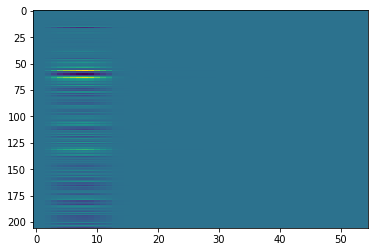

In [15]:
plt.imshow(gridd, aspect="auto")
plt.show()

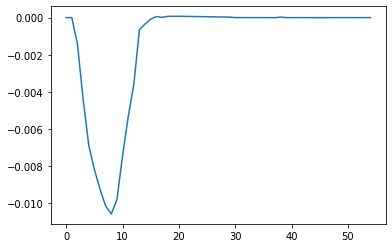

In [29]:
plt.plot(gridd[55,:])
plt.show()

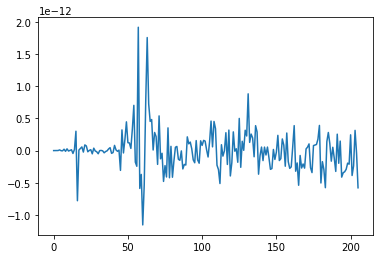

In [25]:
plt.plot(gridd[:,1])
plt.show()

In [31]:
gridd.shape

(206, 55)

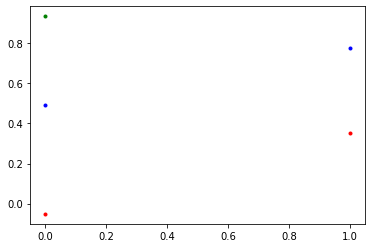

In [24]:
plt.plot(r2_p,".", color="green")
plt.plot(r2_c, ".", color="blue")
plt.plot(r2_cv,".", color="red")
plt.show()

In [124]:
r2_cv

array([-0.0514364 ,  0.35148579,  0.40597082,  0.31184064, -0.25121104,
       -1.72667183, -4.43688267])

In [23]:
gridCought.best_params_

{'n_components': 2}

In [126]:
gridCought.best_estimator_

Tri_PLS1_grid(n_components=3)

In [127]:
r2_p

0.9590896845887107

In [128]:
r2_c

array([ 0.49386191,  0.77650884,  0.86406307,  0.76948651,  0.38032812,
       -0.56928702, -2.98095866])

# Строю R2 по новому

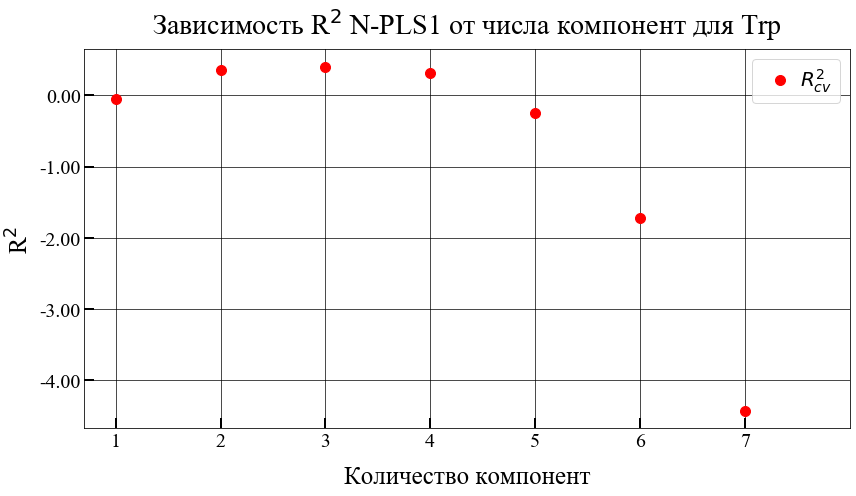

In [132]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(r2_cv,".",color="red",ms=20,label='$R_{cv}^{2}$')
#axs.plot(r2_c,".",color="blue",ms=20,label='$R_c^{2}$')
#axs.plot(r2_p,".",color="green",ms=20,label='$R_p^{2}$')

axs.set_xticks(range(0,7,1)) # Задаём места, где будет сетка и метки по оси ох

axs.set_ylabel('R$^{2}$',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Количество компонент",  fontsize=25,labelpad=15)
axs.set_title("Зависимость R$^{2}$ N-PLS1 от числа компонент для Trp", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(1,9,1), fontsize=20)
axs.set_yticklabels(['-5.00','-4.00','-3.00','-2.00','-1.00','0.00','1.00','0.40','0.92','0.94','1.00'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
axs.legend(loc=1,fontsize=20, markerscale=1,handletextpad=0)

axs.set_xlim(xmax=7) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

plt.savefig('N-PLS1 Trp.png', format='png', dpi=300)
plt.savefig("N-PLS1 Trp.svg", format="svg")


plt.show();

# Строю введено-найдено по новому

In [133]:
yTest=y_test+result.medium

In [134]:
y_test

array([-1.17878692, -0.51935278,  1.8083062 , -1.49703176, -1.2909683 ])

In [135]:
yTest

array([1.32654998, 1.98598412, 4.3136431 , 1.00830513, 1.21436859])

In [136]:
n_predictors=predictors+result.medium

In [137]:
n_predictors

array([1.53252589, 1.65251449, 4.62741765, 0.78587618, 1.25032648])

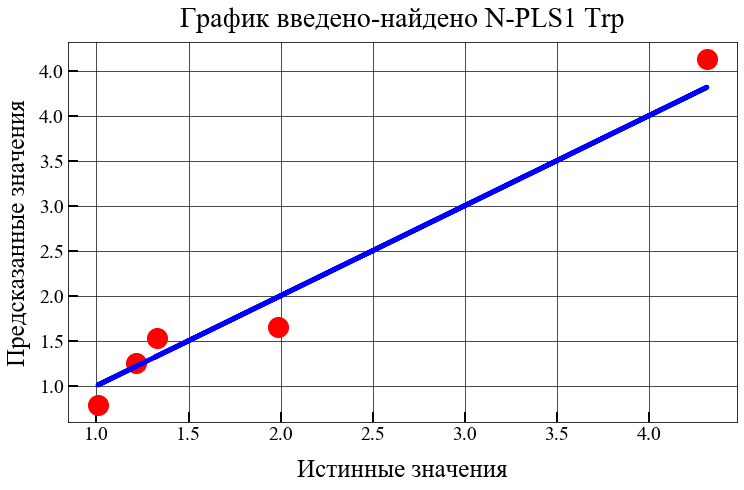

In [140]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(yTest,n_predictors,".",color="red",ms=40)
axs.plot(yTest,yTest,color="blue",lw=5)
axs.set_ylabel("Предсказанные значения" , fontsize=25,labelpad=8)
axs.grid(color="black",linewidth=0.7)
axs.set_xlabel("Истинные значения",  fontsize=25,labelpad=15)
axs.set_title("График введено-найдено N-PLS1 Trp", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
axs.set_xticklabels(['0.5','1.0','1.5','2.0','2.5','3.0','3.5',
                     '4.0','4.0','47.5','50.0'], fontsize=20)
axs.set_yticklabels(['0.5','1.0','1.5','2.0','2.5','3.0','3.5',
                     '4.0','4.0','47.5','50.0'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
plt.savefig('График введено-найдено N-PLS1 Trp.png', format='png', dpi=300)
plt.savefig("График введено-найдено N-PLS1 Trp.svg", format="svg")
plt.show();

# Сохраним абсолютно всё в пикль, потому что считать заново - это очень долго.

In [141]:
pkl.dump(
	{'r2_cv': r2_cv, 'r2_c': r2_c, 'r2_p': r2_p, 'predict':predictors,'y_test':y_test,
     'parametrs':gridCought.best_params_, 'True_predictors':n_predictors, 'True_y':yTest,
     'X_test':X_test,'X_train':X_train,'y_train':y_train},
	open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'wb')
)

### Зделаю ка я применение двух предыдущих классов тоже в виде класса

In [327]:
class run_class(RegressorMixin,BaseEstimator):
    def  __init__(self, testSize=0.1428, column_y=0, components_array=range(1,17), number_vallidations=5):
        self.testSize = testSize
        self.column_y=column_y
        self.components_array = components_array
        self.number_vallidations=number_vallidations
        
    def data_centerng(self,x,y):
        data=centrir(testSize=self.testSize, column_y=self.column_y)
        self.data_cv=data.centering_and_cv(x.copy(),y.copy())
        return self
    
    def cv(self):
        train_error=np.zeros([len(self.components_array)])
        test_error=np.zeros([len(self.components_array)])
        p_error=np.zeros([len(self.components_array)])
        n=0
        for i in self.components_array:
            regressioModel=Tri_PLS1_grid()
            parametrsNames={ 
                'n_components': [i]
            }

            gridCought=GridSearchCV(regressioModel, parametrsNames, cv=self.number_vallidations, return_train_score=True)
            gridCought.fit(self.data_cv.X_train.copy(),self.data_cv.y_train.copy())
            train_error[n]=gridCought.cv_results_[ "mean_train_score"]
            test_error[n]=gridCought.cv_results_[ "mean_test_score" ]
            
            p_error[n]=gridCought.score(self.data_cv.X_test.copy(),self.data_cv.y_test.copy())
            n+=1
        self.train_error=train_error
        self.test_error=test_error
        self.p_error=p_error
        plt.plot(train_error,".", color="red")
        plt.plot(test_error,".", color="blue")
        plt.plot(p_error,".", color="green")
        plt.show();
        return self

In [328]:
mod=run_class(testSize=0.1428,components_array=range(1,13),number_vallidations=5)

In [329]:
#mod.data_centerng(Xdata_numpy["X"][:,160:200,0:15],Ydata)

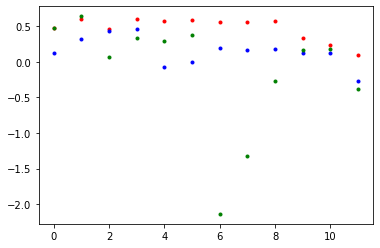

Wall time: 21.6 s


In [330]:
%%time
mod.data_centerng(Xdata_numpy["X"][:,150:200,0:20],Ydata)
result=mod.cv()

In [331]:
result

run_class(column_y=0, components_array=range(1, 13), number_vallidations=5,
          testSize=0.1428)

In [332]:
result.train_error

array([0.46931723, 0.60565466, 0.4612    , 0.60484968, 0.57221136,
       0.58184412, 0.56203913, 0.55663922, 0.56657806, 0.33714295,
       0.23930075, 0.09730211])

In [ ]:
# Пример из интернета, почитаю на досуге
def pls_variable_selection(X, y, max_comp):  
    # Define MSE array to be populated 
    mse = np.zeros((max_comp,X.shape[1])) 
    # Loop over the number of PLS components 
    for i in range(max_comp): 
        # Regression with specified number of components, using full spectrum 
        pls1 = PLSRegression(n_components=i+1) 
        pls1.fit(X, y) 
        # Indices of sort spectra according to ascending absolute value of PLS coefficients 
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0])) 
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind] 
        # Discard one wavelength at a time of the sorted spectra, 
        # regress, and calculate the MSE cross-validation 
        for j in range(Xc.shape[1]-(i+1)): 
            pls2 = PLSRegression(n_components=i+1) 
            pls2.fit(Xc[:, j:], y) 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5) 
            mse[i,j] = mean_squared_error(y, y_cv) 
            comp = 100*(i+1)/(max_comp) 
            stdout.write("\r%d%% completed" % comp) 
            stdout.flush() 
            stdout.write("\n") 
            # # Calculate and print the position of minimum in MSE 
            mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)])) 
            print("Optimised number of PLS components: ", mseminx[0]+1) 
            print("Wavelengths to be discarded ",mseminy[0]) 
            print('Optimised MSEP ', mse[mseminx,mseminy][0]) 
            stdout.write("\n") 
            # plt.imshow(mse, interpolation=None) 
    # plt.show() # Calculate PLS with optimal components and export values 
    pls = PLSRegression(n_components=mseminx[0]+1) 
    pls.fit(X, y) sorted_ind = np.argsort(np.abs(pls.coef_[:,0])) 
    Xc = X[:,sorted_ind] 
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)